In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
import pandas as pd
import requests

url = "https://data.cityofnewyork.us/resource/erm2-nwe9.json?$$app_token=a0ZbYGyo6mI8pQ0uwdOPp8y5P"
response = requests.get(url)
data = response.json()
df = pd.DataFrame(data)


In [ ]:
!pip install sodapy
import pandas as pd
from sodapy import Socrata
import os

app_token = os.environ.get("SOCRATA_TOKEN")# Get token from environment variable
username = "asso796@gmail.com"
password = os.environ.get("SOCRATA_PASSWORD") # Get password from environment variable

if password is None:
    raise ValueError("SOCRATA_PASSWORD environment variable not set.")

client = Socrata(
    "data.cityofnewyork.us",
    app_token,
    username=username,
    password=password,
    timeout=60,
)

# Get the total number of records (using the efficient count(*) query)
count_results = client.get("erm2-nwe9",
                         select="count(*)"
                         )
total_records = int(count_results[0]['count'])  # Extract the count
print(f"Total matching records: {total_records}")

# Pagination loop with progress reporting
all_data = []
limit = 1000000  # Reduced page size, try 10000 or even lower (5000, 1000) if needed
offset = 0
retrieved_records = 0  # Keep track of how many we've fetched

while retrieved_records < total_records:  # More precise loop condition
    print(f"Fetching rows {offset} to {offset + limit}...")
    try:
        results = client.get("erm2-nwe9",
                             limit=limit,
                             offset=offset,
                             select="created_date, closed_date, agency, complaint_type, descriptor, location_type, \
                             incident_zip ,city, borough, latitude, longitude, open_data_channel_type, \
                             community_board, facility_type"
                             )

        df_page = pd.DataFrame.from_records(results)
        if df_page.empty:  # Still a good safety check
            break

        all_data.append(df_page)
        offset += limit
        retrieved_records += len(df_page)  # Update the count of retrieved records

        # Progress reporting (percentage)
        percent_complete = (retrieved_records / total_records) * 100
        print(f"Progress: {percent_complete:.2f}%")


    except Exception as e:
        print(f"An error occurred: {e}")
        # Implement a retry mechanism (optional, but recommended for large datasets)
        print("Retrying in 10 seconds...")
        import time
        time.sleep(10)  # Wait for a short period before retrying

# Concatenate and convert data types
final_df = pd.concat(all_data, ignore_index=True)

# Convert created_date after the loop to minimize type conversions within the loop
final_df['created_date'] = pd.to_datetime(final_df['created_date'])
final_df['closed_date'] = pd.to_datetime(final_df['closed_date'])
# Convert incident_zip to numeric, handle errors by coercing invalid values to NaN
final_df['incident_zip'] = pd.to_numeric(final_df['incident_zip'], errors='coerce')

print(len(final_df))

Total matching records: 39218423
Fetching rows 0 to 1000000...
Progress: 2.55%
Fetching rows 1000000 to 2000000...
Progress: 5.10%
Fetching rows 2000000 to 3000000...
Progress: 7.65%
Fetching rows 3000000 to 4000000...
Progress: 10.20%
Fetching rows 4000000 to 5000000...
Progress: 12.75%
Fetching rows 5000000 to 6000000...
Progress: 15.30%
Fetching rows 6000000 to 7000000...
Progress: 17.85%
Fetching rows 7000000 to 8000000...
Progress: 20.40%
Fetching rows 8000000 to 9000000...
Progress: 22.95%
Fetching rows 9000000 to 10000000...
Progress: 25.50%
Fetching rows 10000000 to 11000000...
Progress: 28.05%
Fetching rows 11000000 to 12000000...
Progress: 30.60%
Fetching rows 12000000 to 13000000...
Progress: 33.15%
Fetching rows 13000000 to 14000000...
Progress: 35.70%
Fetching rows 14000000 to 15000000...
Progress: 38.25%
Fetching rows 15000000 to 16000000...
Progress: 40.80%
Fetching rows 16000000 to 17000000...
Progress: 43.35%
Fetching rows 17000000 to 18000000...
Progress: 45.90%
Fetch

In [ ]:
!pip install findspark
import findspark
findspark.init()

In [ ]:
from google.colab import drive  # Import the drive module
import os
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


from pyspark.sql import SparkSession

# Assuming 'final_df' from your previous code is still in memory
# If not, load the CSV file you saved earlier.

spark = SparkSession.builder.appName("ReadCSV").getOrCreate()

# Replace with the actual path to your CSV file
file_path = '/content/drive/MyDrive/Colab Notebooks/NYC/nyc_311_data.csv'

df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Now you can work with the PySpark DataFrame 'df_spark'
df_spark.printSchema()
df_spark.show(5)


root
 |-- created_date: timestamp (nullable = true)
 |-- closed_date: timestamp (nullable = true)
 |-- agency: string (nullable = true)
 |-- complaint_type: string (nullable = true)
 |-- descriptor: string (nullable = true)
 |-- location_type: string (nullable = true)
 |-- incident_zip: double (nullable = true)
 |-- city: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- open_data_channel_type: string (nullable = true)
 |-- community_board: string (nullable = true)
 |-- facility_type: string (nullable = true)

+-------------------+-------------------+------+--------------------+--------------------+--------------------+------------+----------------+---------+------------------+------------------+----------------------+---------------+-------------+
|       created_date|        closed_date|agency|      complaint_type|          descriptor|       location_type|incident_zip|            city|

In [ ]:

RESULT = spark.sql("""
  SELECT UPPER(CITY) AS CITY, COUNT(*) AS COMPLAINT_COUNT
  FROM NYC311
  GROUP BY UPPER(CITY)
  ORDER BY COMPLAINT_COUNT DESC
  LIMIT 10
""")
RESULT.show()


+-------------+---------------+
|         CITY|COMPLAINT_COUNT|
+-------------+---------------+
|     BROOKLYN|       11603527|
|     NEW YORK|        7392377|
|        BRONX|        7249489|
|         NULL|        2150236|
|STATEN ISLAND|        1840677|
|      JAMAICA|         926220|
|     FLUSHING|         670600|
|      ASTORIA|         642581|
|    RIDGEWOOD|         493716|
|       CORONA|         317630|
+-------------+---------------+



In [ ]:
result2 = spark.sql("""
  SELECT complaint_type, COUNT(*) AS count
  FROM nyc311
  GROUP BY complaint_type
  ORDER BY count DESC
  LIMIT 10
""")
result2.show(truncate=False)


+-----------------------+-------+
|complaint_type         |count  |
+-----------------------+-------+
|Noise - Residential    |3530794|
|Illegal Parking        |2761322|
|HEAT/HOT WATER         |2618138|
|Blocked Driveway       |1704377|
|Street Condition       |1421226|
|Noise - Street/Sidewalk|1282116|
|Street Light Condition |1197072|
|PLUMBING               |1000642|
|UNSANITARY CONDITION   |991713 |
|Water System           |990493 |
+-----------------------+-------+



In [ ]:
# Register DataFrame as a temporary view


# SQL Query: Find most frequent complaint type for top 10 cities
result = spark.sql("""
WITH top_cities AS (
  SELECT UPPER(CITY) AS CITY, COUNT(*) AS COMPLAINT_COUNT
  FROM NYC311
  GROUP BY UPPER(CITY)
  ORDER BY COMPLAINT_COUNT DESC
  LIMIT 10
),
city_complaints AS (
    SELECT n.city, n.complaint_type, COUNT(*) AS type_count
    FROM nyc311 n
    INNER JOIN top_cities t ON n.city = t.city
    GROUP BY n.city, n.complaint_type
),
ranked_complaints AS (
    SELECT city, complaint_type, type_count,
           ROW_NUMBER() OVER (PARTITION BY city ORDER BY type_count DESC) AS rn
    FROM city_complaints
)
SELECT city, complaint_type, type_count
FROM ranked_complaints
WHERE rn = 1
ORDER BY type_count DESC
""")

# Show the results
result.show()


+-------------+-------------------+----------+
|         city|     complaint_type|type_count|
+-------------+-------------------+----------+
|        BRONX|Noise - Residential|   1020630|
|     BROOKLYN|Noise - Residential|    972989|
|     NEW YORK|Noise - Residential|    721546|
|STATEN ISLAND|   Street Condition|    166889|
|      JAMAICA|Noise - Residential|     84330|
|    RIDGEWOOD|    Illegal Parking|     69396|
|     FLUSHING|   Blocked Driveway|     61834|
|      ASTORIA|    Illegal Parking|     61054|
|       CORONA|   Blocked Driveway|     56759|
+-------------+-------------------+----------+



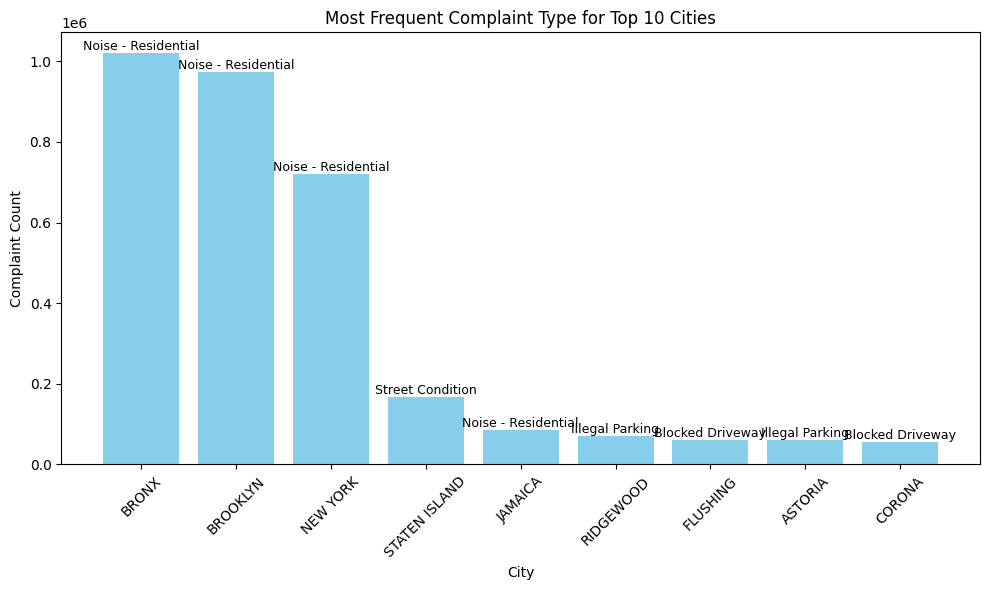

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
df = result.toPandas()

# Create a bar chart
plt.figure(figsize=(10,6))
bars = plt.bar(df['city'], df['type_count'], color='skyblue')

# Annotate each bar with the complaint type
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             df['complaint_type'][i], ha='center', va='bottom', fontsize=9)

plt.xlabel("City")
plt.ylabel("Complaint Count")
plt.title("Most Frequent Complaint Type for Top 10 Cities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
